# Fraudulent Activities - PART I

### OBJECTIF

Les sites de E-commerce font transiter beaucoup d'argent. Cela peut engendrer des risques non négligeables d'activités frauduleuses, comme l'utilisation de carte de crédit volées, du blanchiment d'argent, etc.

Fort heureusement, le Machine Learning peut nous aider à identifier ces activités frauduleuses. Tous les sites web où vous devez entrer vos informations de paiements ont une équipe qui s'occupe de gérer les risques de fraude via le ML.

Le but de ce challenge est de construire un modèle qui vous permet de prédire une probabilité de transaction frauduleuse.

### DESCRIPTION

L'entreprise X fait du E-commerce et vend des vêtements faits-main. Votre but est de construire un modèle qui permette de prédire si l'achat d'un vêtement doit être considéré comme une transaction frauduleuse ou non.

Voici précisément ce que vous devez faire :

1. Pour chacun des utilisateurs, déterminez le pays d'origine depuis son adresse IP

2. Construisez un modèle qui permette de prédire si l'activité est frauduleuse ou non. Expliquez aussi vos choix / hypothèses en termes d'optimisation de faux-positifs et faux-négatifs

3. Votre patron aimerait comprendre votre modèle car il est inquiet d'utiliser un modèle _black box_. Comment l'expliqueriez vous d'un point utilisateur, et non pas mathématique. Par exemple, quels sont les utilisateurs qui peuvent être classés comme _risqués_ ?

4. Supposons que vous pouvez utiliser votre modèle en live pour qu'il fasse sa prédiction en temps réel. D'un point de vue Produit, comment l'utiliseriez-vous ? Comment pourriez-vous penser l'expérience utilisateur face à ce produit ?


### DATA

Vous pouvez utiliser les deux tables suivantes :

```python
Fraud_Data
```

&

```python
IpAddress_to_Country
```


In [1]:
!pip install s3fs

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
df1 = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/fraudulent_activity/Fraud_Data.csv")
ip_country = pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/projects/fraudulent_activity/IpAddress_to_Country.csv")

In [4]:
def transform_ip(arg) :
    try :
        return ip_country.country[(ip_country.lower_bound_ip_address < arg) & (ip_country.upper_bound_ip_address > arg)].iloc[0]
    except IndexError :
        return "Pays inconnu"  
df1["country_name"] = df1.ip_address.apply(transform_ip)

In [5]:
%time
dataset = df1

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


# BASIS STATISTIC

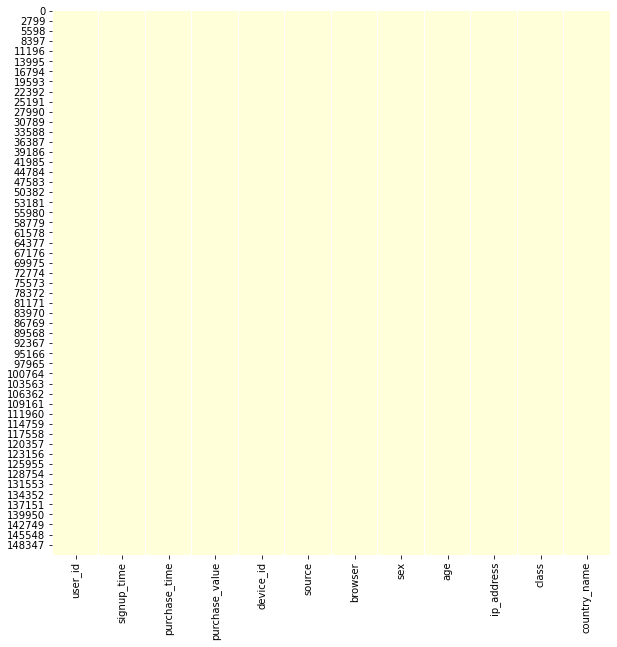

In [6]:
plt.figure(figsize=(10,10))
sns.heatmap(dataset.isnull(),cbar=False,cmap='YlGnBu')
plt.ioff()

In [7]:
# Basic stats
print("Number of rows : {} and number of columns is : {}".format(dataset.shape[0],dataset.shape[1]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
dataset.info()
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 151112 and number of columns is : 12

Display of dataset: 


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Pays inconnu
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States



Basics statistics: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
 11  country_name    151112 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country_name
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000,151112
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN,182
top,NaN,2015-06-29 23:51:43,2015-07-17 23:22:55,NaN,KIPFSCNUGOLDP,SEO,Chrome,M,NaN,NaN,NaN,United States
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN,58049
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646,NaN
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336,NaN
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000,NaN
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000,NaN
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000,NaN
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000,NaN



Percentage of missing values: 


user_id           0.0
signup_time       0.0
purchase_time     0.0
purchase_value    0.0
device_id         0.0
source            0.0
browser           0.0
sex               0.0
age               0.0
ip_address        0.0
class             0.0
country_name      0.0
dtype: float64

In [8]:
dataset2 = dataset




In [9]:
dataset3 =dataset2.drop(['user_id','device_id','ip_address'],axis=1)

# FEATURE ENGENNERING

## Time featuring

Our main issue there is to transforme str of ttime columns in dataetime and then in quantitative value to strat a processoring on it

In [10]:
from datetime import datetime as dt
import datetime




In [11]:
dataset3['purchase_time'] = dataset3['purchase_time'].apply(lambda x: pd.to_datetime(x))
dataset3['signup_time'] = dataset3['signup_time'].apply(lambda x: pd.to_datetime(x))

In [12]:
import datetime
dataset3['p_day'] = dataset3['purchase_time'].dt.day
dataset3['p_month'] = dataset3['purchase_time'].dt.month
dataset3['p_years'] =dataset3['purchase_time'].dt.year
dataset3['s_day'] = dataset3['signup_time'].dt.day
dataset3['s_month'] = dataset3['signup_time'].dt.month
dataset3['s_years'] = dataset3['signup_time'].dt.year
dataset3['m_s_p'] =dataset3['p_month']/(dataset3['p_month']+dataset3['s_month'])
dataset3['d_s_p'] = dataset3['p_day']/(dataset3['p_day']+dataset3['s_day'])
dataset3['d_s_msp'] = dataset3['s_day']/(dataset3['p_month']+dataset3['s_month'])
dataset3=dataset3.drop(['purchase_time','signup_time'],axis=1)

In [13]:
#dataset3['purchase_time'] = dataset3['purchase_time'].apply(lambda x: pd.to_datetime(x).timestamp())
#dataset3['signup_time'] = dataset3['signup_time'].apply(lambda x: pd.to_datetime(x).timestamp())


In [14]:
dataset3['p_years'].unique()
dataset3['s_years'].unique()
dataset3 = dataset3.drop(['s_years','p_years'],axis = 1)
dataset3.head()

,purchase_value,source,browser,sex,age,class,country_name,p_day,p_month,s_day,s_month,m_s_p,d_s_p,d_s_msp
0,34,SEO,Chrome,M,39,0,Japan,18,4,24,2,0.666667,0.428571,4.000000
1,16,Ads,Chrome,F,53,0,United States,8,6,7,6,0.500000,0.533333,0.583333
2,15,SEO,Opera,M,53,1,United States,1,1,1,1,0.500000,0.500000,0.500000
3,44,SEO,Safari,M,41,0,Pays inconnu,4,5,28,4,0.555556,0.125000,3.111111
4,39,Ads,Safari,M,45,0,United States,9,9,21,7,0.562500,0.300000,1.312500


## Country FEATURING


Our main issue there is to group and keep main countries'values number cause they have many modalities (182) 

In [15]:
print(dataset3['class'].value_counts())
print(dataset3['class'].value_counts(normalize = True))

0    136961
1     14151
Name: class, dtype: int64
0    0.906354
1    0.093646
Name: class, dtype: float64


In [16]:
dataset3['country_name'].value_counts().sum()

151112

In [17]:
dataset3['freq_country'] = dataset3.groupby('country_name')['country_name'].transform('count')
dataset3

,purchase_value,source,browser,sex,age,class,country_name,p_day,p_month,s_day,s_month,m_s_p,d_s_p,d_s_msp,freq_country
0,34,SEO,Chrome,M,39,0,Japan,18,4,24,2,0.666667,0.428571,4.000000,7306
1,16,Ads,Chrome,F,53,0,United States,8,6,7,6,0.500000,0.533333,0.583333,58049
2,15,SEO,Opera,M,53,1,United States,1,1,1,1,0.500000,0.500000,0.500000,58049
3,44,SEO,Safari,M,41,0,Pays inconnu,4,5,28,4,0.555556,0.125000,3.111111,21966
4,39,Ads,Safari,M,45,0,United States,9,9,21,7,0.562500,0.300000,1.312500,58049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,43,SEO,Chrome,M,28,1,United States,29,3,27,1,0.750000,0.517857,6.750000,58049
151108,35,SEO,Safari,M,32,0,Netherlands,26,5,15,5,0.500000,0.634146,1.500000,1680
151109,40,SEO,IE,F,26,0,Japan,20,5,3,3,0.625000,0.869565,0.375000,7306
151110,46,SEO,Chrome,M,37,0,United States,7,9,9,7,0.562500,0.437500,0.562500,58049


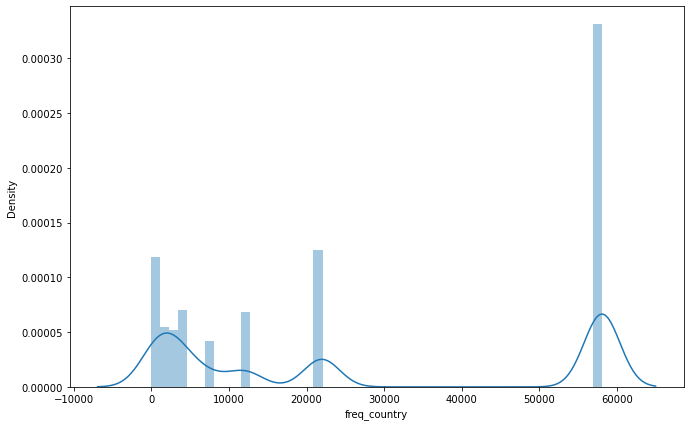

In [18]:

plt.subplots(figsize=(11, 7))
sns.distplot(dataset3['freq_country'], bins=50)
plt.show()

In [19]:
dataset3['freq_country'].unique()

array([ 7306, 58049, 21966,  2975, 12038,  2961,  1310,   661,  4490,
         838,  3646,  1121,  1090,  4162,   119,   229,    37,  3161,
        1237,  1616,   409,   490,  1680,   389,  1027,     9,   264,
         471,    32,    24,   568,   278,   238,  1844,   429,   435,
         272,   210,   231,  1944,   609,   729,   251,   291,   417,
         158,   460,   211,   649,   602,   106,    95,   785,   550,
          67,   359,    92,    93,    22,    25,    53,   166,   525,
          79,    43,   349,   122,    18,   208,     7,   114,    35,
         118,    51,   186,    16,    42,    23,    90,   240,    13,
          41,    80,    28,    30,     2,     1,    19,   177,    62,
           5,    20,    11,    64,    87,    14,    15,    17,    86,
          69,    72,     6,     3,    31,    10,     4])

In [20]:

dataset3 =dataset3.loc[dataset3['freq_country'] >= 1310, :]



In [21]:
dataset3['country_name'].value_counts()

United States         58049
Pays inconnu          21966
China                 12038
Japan                  7306
United Kingdom         4490
Korea Republic of      4162
Germany                3646
France                 3161
Canada                 2975
Brazil                 2961
Italy                  1944
Australia              1844
Netherlands            1680
Russian Federation     1616
India                  1310
Name: country_name, dtype: int64

In [22]:
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('India','Asia'))
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('China','Asia'))  
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('Korea Republic of','Asia'))  
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('Japan','Asia')) 

dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('Russian Federation','Europe')) 
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('Netherlands','Europe'))
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('Germany','Europe'))
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('United Kingdom','Europe'))
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('France','Europe'))
dataset3['country_name'] = dataset3['country_name'].apply(lambda x: x.replace('Italy','Europe'))



dataset3.country_name.value_counts()

United States    58049
Asia             24816
Pays inconnu     21966
Europe           16537
Canada            2975
Brazil            2961
Australia         1844
Name: country_name, dtype: int64

In [23]:

dataset3 =dataset3.loc[dataset3['country_name']  != 'Australia', :]
dataset3 =dataset3.loc[dataset3['country_name']  != 'Brazil', :]
ataset3 =dataset3.loc[dataset3['country_name']  != 'Canada', :]

dataset3 =dataset3.drop(['freq_country'],axis=1)
dataset3.country_name.value_counts()



United States    58049
Asia             24816
Pays inconnu     21966
Europe           16537
Canada            2975
Name: country_name, dtype: int64

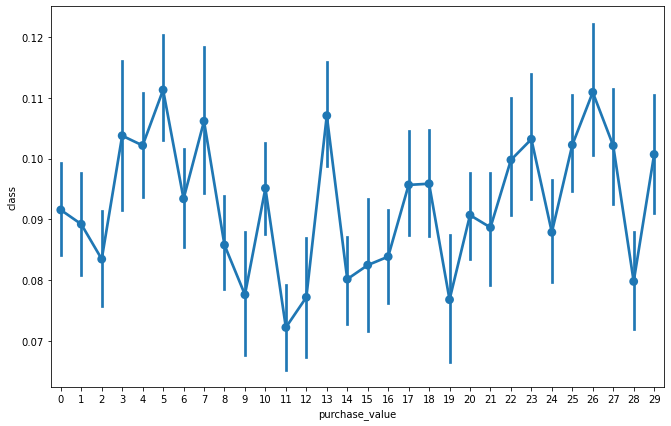

In [24]:
plt.subplots(figsize=(11, 7))
sns.pointplot(x=pd.qcut(dataset3['purchase_value'],30,labels=False, duplicates='drop'),y=dataset2['class'], data=dataset2) # les barres = barres d'erreurs
plt.show()


In [25]:
dataset3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124343 entries, 0 to 151111
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   purchase_value  124343 non-null  int64  
 1   source          124343 non-null  object 
 2   browser         124343 non-null  object 
 3   sex             124343 non-null  object 
 4   age             124343 non-null  int64  
 5   class           124343 non-null  int64  
 6   country_name    124343 non-null  object 
 7   p_day           124343 non-null  int64  
 8   p_month         124343 non-null  int64  
 9   s_day           124343 non-null  int64  
 10  s_month         124343 non-null  int64  
 11  m_s_p           124343 non-null  float64
 12  d_s_p           124343 non-null  float64
 13  d_s_msp         124343 non-null  float64
dtypes: float64(3), int64(7), object(4)
memory usage: 19.2+ MB


In [26]:
dataset3.corr()

,purchase_value,age,class,p_day,p_month,s_day,s_month,m_s_p,d_s_p,d_s_msp
purchase_value,1.000000,0.002519,0.004221,-0.001104,0.005479,-0.005028,0.005469,-0.002549,0.001911,-0.004478
age,0.002519,1.000000,0.003962,-0.001707,-0.002510,-0.000830,-0.004442,0.002374,-0.002230,-0.001560
class,0.004221,0.003962,1.000000,-0.158992,-0.306704,-0.155399,-0.227518,-0.199680,-0.003798,0.127857
p_day,-0.001104,-0.001707,-0.158992,1.000000,0.008913,0.046220,0.088100,-0.096538,0.649761,0.017598
p_month,0.005479,-0.002510,-0.306704,0.008913,1.000000,0.127825,0.882833,-0.068606,-0.093234,-0.549897
s_day,-0.005028,-0.000830,-0.155399,0.046220,0.127825,1.000000,-0.009898,0.242778,-0.651914,0.559996
s_month,0.005469,-0.004442,-0.227518,0.088100,0.882833,-0.009898,1.000000,-0.479431,0.062344,-0.589721
m_s_p,-0.002549,0.002374,-0.199680,-0.096538,-0.068606,0.242778,-0.479431,1.000000,-0.240686,0.267556
d_s_p,0.001911,-0.002230,-0.003798,0.649761,-0.093234,-0.651914,0.062344,-0.240686,1.000000,-0.371459
d_s_msp,-0.004478,-0.001560,0.127857,0.017598,-0.549897,0.559996,-0.589721,0.267556,-0.371459,1.000000


## X & Y 

In [27]:
target_name = 'class'

print("Separating labels from features...")


Y = dataset3.loc[:,target_name]
X = dataset3.loc[:,[c for c in dataset3.columns if c!=target_name]] # Keeping all columns
print("...Done.")
print(Y)
print()
print(X)
print()

Separating labels from features...
...Done.
0         0
1         0
2         1
3         0
4         0
         ..
151107    1
151108    0
151109    0
151110    0
151111    0
Name: class, Length: 124343, dtype: int64

        purchase_value  source browser sex  age   country_name  p_day  \
0                   34     SEO  Chrome   M   39           Asia     18   
1                   16     Ads  Chrome   F   53  United States      8   
2                   15     SEO   Opera   M   53  United States      1   
3                   44     SEO  Safari   M   41   Pays inconnu      4   
4                   39     Ads  Safari   M   45  United States      9   
...                ...     ...     ...  ..  ...            ...    ...   
151107              43     SEO  Chrome   M   28  United States     29   
151108              35     SEO  Safari   M   32         Europe     26   
151109              40     SEO      IE   F   26           Asia     20   
151110              46     SEO  Chrome   M   37  Un

In [31]:
print("Convert pandas DataFrames to numpy arrays...")
X = X.values
Y = Y.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[34 'SEO' 'Chrome' 'M' 39 'Asia' 18 4 24 2 0.6666666666666666
  0.42857142857142855 4.0]
 [16 'Ads' 'Chrome' 'F' 53 'United States' 8 6 7 6 0.5 0.5333333333333333
  0.5833333333333334]
 [15 'SEO' 'Opera' 'M' 53 'United States' 1 1 1 1 0.5 0.5 0.5]
 [44 'SEO' 'Safari' 'M' 41 'Pays inconnu' 4 5 28 4 0.5555555555555556
  0.125 3.111111111111111]
 [39 'Ads' 'Safari' 'M' 45 'United States' 9 9 21 7 0.5625 0.3 1.3125]]

[0, 0, 1, 0, 0]


print("Convert pandas DataFrames to numpy arrays...")
X=X.values
Y = Y.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])
import scipy as sp 
import numpy as np 


In [32]:

print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify =Y)

print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [33]:

numeric_features = [0,4]
numeric_transformer = StandardScaler(with_mean=False)
labelencoder = LabelEncoder()

categorical_features = [1,2,3,5]

label_features=[6,7,8,9]

categorical_transformer = OneHotEncoder()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],remainder ='passthrough',sparse_threshold=0)

In [34]:
# Preprocessings on train set
print("Performing preprocessings on train set...")

print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test) 

print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[16 'Ads' 'Safari' 'M' 45 'Pays inconnu' 10 8 26 4 0.6666666666666666
  0.2777777777777778 2.1666666666666665]
 [20 'Ads' 'FireFox' 'M' 33 'United States' 17 5 6 2 0.7142857142857143
  0.7391304347826086 0.8571428571428571]
 [67 'Ads' 'Chrome' 'M' 28 'Pays inconnu' 16 2 6 2 0.5 0.7272727272727273
  1.5]
 [34 'Ads' 'Safari' 'F' 32 'Asia' 5 1 5 1 0.5 0.5 2.5]
 [41 'SEO' 'IE' 'F' 27 'Europe' 17 7 16 4 0.6363636363636364
  0.5151515151515151 1.4545454545454546]]
...Done.
[[0.8719843263976392 5.2164583893861804 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0
  0.0 1.0 0.0 0.0 0.0 1.0 0.0 10 8 26 4 0.6666666666666666
  0.2777777777777778 2.1666666666666665]
 [1.089980407997049 3.8254028188831994 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0
  0.0 1.0 0.0 0.0 0.0 0.0 1.0 17 5 6 2 0.7142857142857143
  0.7391304347826086 0.8571428571428571]
 [3.6514343667901143 3.2457963311736235 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0
  0.0 1.0 0.0 0.0 0.0 1.0 0.0 16 2 6 2 0.5 0.7272727272727273 1.5]
 [1.

In [35]:
labelencoder = LabelEncoder()

print("Encoding labels on train set...")
print(Y_train[0:5])
print()
Y_train = labelencoder.fit_transform(Y_train)
print("...Done.")
print(Y_train[0:5])
print()

print("Encoding labels on test set...")
print(Y_test[0:5])
print()
Y_test = labelencoder.transform(Y_test) # Don't fit again !!
print("...Done.")
print(Y_test[0:5])
print()

Encoding labels on train set...
[0, 0, 0, 1, 0]

...Done.
[0 0 0 1 0]

Encoding labels on test set...
[0, 0, 0, 0, 1]

...Done.
[0 0 0 0 1]



In [ ]:
!pip install imblearn

# Logitic Regression


In [36]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score

# Train model
model = LogisticRegression()

print("Training model...")
model.fit(X_train, Y_train) # Training is always done on train set !!
print("...Done.")


# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))

Training model...
...Done.
Predictions on training set...
...Done.
[0 0 0 1 0]

Predictions on test set...
...Done.
[0 0 0 0 0]


............Accuracy score ...........
Accuracy on training set :  0.9506433823529412
Accuracy on test set :  0.9524435032034957

............Precision measure ...........
Precision score on test set :  0.8980169971671388

............Precision score...........
Precision score on test set :  0.5497109826589596

............F1 score ...........
"F1 score on training set is : 0.6650031191515908
"F1 score on training set is : 0.6819648619576909


### A other way to visualise our score 

In [39]:
from sklearn.metrics import classification_report


print(classification_report(y_true=Y_train, y_pred=model.predict(X_train),digits=5))
print(classification_report(y_true=Y_test, y_pred=model.predict(X_test)))

              precision    recall  f1-score   support

           0    0.95371   0.99383   0.97336     78967
           1    0.89750   0.52818   0.66500      8073

    accuracy                        0.95064     87040
   macro avg    0.92560   0.76101   0.81918     87040
weighted avg    0.94850   0.95064   0.94476     87040

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     33843
           1       0.90      0.55      0.68      3460

    accuracy                           0.95     37303
   macro avg       0.93      0.77      0.83     37303
weighted avg       0.95      0.95      0.95     37303



### Trying to observe wich variables of X are usefull and have a significance effect on our Y ariable

In [40]:
from sklearn.feature_selection import chi2

feature_importance = chi2(X_train, Y_train)


feature_importance

(array([1.99428540e+00, 5.30712040e-01, 3.89318381e-02, 2.86223032e+01,
        1.30101131e+01, 1.10875365e+01, 4.45890300e-01, 4.07907361e+00,
        2.08656173e-01, 3.73787424e+00, 3.53330480e+00, 2.51477579e+00,
        6.06670694e-01, 1.45463200e+01, 3.06998271e+00, 1.29136808e+01,
        7.72710257e+00, 1.10778957e+04, 9.30958896e+03, 1.07820025e+04,
        5.37054721e+03, 3.79998399e+01, 8.07187273e-02, 1.98232245e+03]),
 array([1.57893524e-01, 4.66307657e-01, 8.43583761e-01, 8.79631707e-08,
        3.09813227e-04, 8.69098610e-04, 5.04293074e-01, 4.34174567e-02,
        6.47822727e-01, 5.31920770e-02, 6.01477891e-02, 1.12783673e-01,
        4.36044114e-01, 1.36755502e-04, 7.97503200e-02, 3.26189215e-04,
        5.43979743e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.07504346e-10, 7.76325767e-01, 0.00000000e+00]))

In [ ]:
#pd.DataFrame(X_train).info()

# DECISION TREE Gini

In [42]:
from sklearn.tree import plot_tree

In [43]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Train model
classifier_gini= DecisionTreeClassifier(criterion='gini')



print("Training model...")
classifier_gini.fit(X_train, Y_train) # Training is always done on train set !!
print("...Done.")


# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier_gini.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier_gini.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))

Training model...
...Done.
Predictions on training set...
...Done.
[0 0 0 1 0]

Predictions on test set...
...Done.
[0 0 0 0 0]


............Accuracy score ...........
Accuracy on training set :  0.9999770220588236
Accuracy on test set :  0.9045117014717315

............Precision measure ...........
Precision score on test set :  0.487542745481192

............Precision score...........
Precision score on test set :  0.576878612716763

............F1 score ...........
"F1 score on training set is : 0.9998761456527124
"F1 score on training set is : 0.5284617421233784


In [44]:
from sklearn.model_selection import GridSearchCV


params = {'max_depth' : np.arange(1,10),
         'min_samples_split' : [2, 5, 10, 20]}

grid =  GridSearchCV(estimator=classifier_gini, param_grid= params, cv = 10)
grid.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [2, 5, 10, 20]})

In [45]:
grid.best_params_

{'max_depth': 3, 'min_samples_split': 2}

In [46]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = grid.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 1 0]

Predictions on test set...
...Done.
[0 0 0 0 0]


............Accuracy score ...........
Accuracy on training set :  0.9557215073529411
Accuracy on test set :  0.9576977722971343

............Precision measure ...........
Precision score on test set :  0.9952631578947368

............Precision score...........
Precision score on test set :  0.5465317919075144

............F1 score ...........
"F1 score on training set is : 0.6873783257624919
"F1 score on training set is : 0.705597014925373


# DECISION TREE Entropy

In [47]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

# Train model
classifier_entropy= DecisionTreeClassifier(criterion='entropy')



print("Training model...")
classifier_entropy.fit(X_train, Y_train) # Training is always done on train set !!
print("...Done.")


# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier_entropy.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier_entropy.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))

Training model...
...Done.
Predictions on training set...
...Done.
[0 0 0 1 0]

Predictions on test set...
...Done.
[0 0 0 0 0]


............Accuracy score ...........
Accuracy on training set :  0.9999770220588236
Accuracy on test set :  0.908398788301209

............Precision measure ...........
Precision score on test set :  0.5054499366286439

............Precision score...........
Precision score on test set :  0.576300578034682

............F1 score ...........
"F1 score on training set is : 0.9998761456527124
"F1 score on training set is : 0.5385550303848752


In [48]:
from sklearn.model_selection import GridSearchCV


params = {'max_depth' : np.arange(1,10),
         'min_samples_split' : [2, 5, 10, 20]}

grid =  GridSearchCV(estimator=classifier_entropy, param_grid= params, cv = 10)
grid.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'min_samples_split': [2, 5, 10, 20]})

In [49]:
grid.best_params_

{'max_depth': 3, 'min_samples_split': 2}

In [50]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = grid.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))

Predictions on training set...
...Done.
[0 0 0 1 0]

Predictions on test set...
...Done.
[0 0 0 0 0]


............Accuracy score ...........
Accuracy on training set :  0.9557215073529411
Accuracy on test set :  0.9576977722971343

............Precision measure ...........
Precision score on test set :  0.9952631578947368

............Precision score...........
Precision score on test set :  0.5465317919075144

............F1 score ...........
"F1 score on training set is : 0.6873783257624919
"F1 score on training set is : 0.705597014925373


# RANDOM FOREST

In [ ]:
from sklearn.ensemble import BaggingClassifier


classifier_entropy= DecisionTreeClassifier(criterion='entropy', max_depth= 8, min_samples_split = 20)


classifier_random = BaggingClassifier(base_estimator=classifier_entropy, n_estimators=100,max_samples=0.7) #sur les  1000 models testés, elle nus sort le meilleur modéle 
classifier_random.fit(X_train,Y_train)


# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier_random.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred =classifier_random.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))



Predictions on training set...


In [ ]:
from sklearn.model_selection import GridSearchCV


params = {'n_estimators': [1,10,100]}

grid =  GridSearchCV(estimator=classifier_random, param_grid= params, cv = 10,verbose = 2,n_jobs=-1)
grid.fit(X_train, Y_train)

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = grid.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = grid.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# BERNOUILLI Model

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

In [ ]:
from sklearn.preprocessing import Binarizer


X_train_binarize = Binarizer().fit_transform(X_train)  # fit does nothing.
print(X_train_binarize)

X_test_binarize = Binarizer().fit_transform(X_test)
print(X_test_binarize)

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

# Train model

modelBERN = BernoulliNB()


modelBERN.fit(X_train,Y_train)


print(classification_report(y_true=Y_train, y_pred=modelBERN.predict(X_train_binarize)))
print(classification_report(y_true=Y_test, y_pred=modelBERN.predict(X_test_binarize)))

# Gaussian Model

In [ ]:
dataset3.describe()

In [ ]:
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import BaggingClassifier


modelNB = GaussianNB()

# Train model




print("Training model...")
modelNB.fit(X_train, Y_train) # Training is always done on train set !!
print("...Done.")


# Predictions on training set
print("Predictions on training set...")
Y_train_pred = modelNB.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = modelNB.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))


# SVM  Model

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', class_weight='balanced')

print("Training model...")

svm.fit(X_train, Y_train)



print("...Done.")


# Predictions on training set
print("Predictions on training set...")
Y_train_pred = svm.predict(X_train)            
print("...Done.")
print(Y_train_pred[0:5])
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = svm.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])
print()
print('')
print('............Accuracy score ...........')



print("Accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))

print("Accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print('')
from sklearn import metrics


print('............Precision measure ...........')

print("Precision score on test set : ", metrics.precision_score(Y_test, Y_test_pred))
print('')

print('............Precision score...........')



print("Precision score on test set : ", metrics.recall_score(Y_test, Y_test_pred))
print('')


print('............F1 score ...........')
print('"F1 score on training set is :',f1_score(Y_train, Y_train_pred))
print('"F1 score on training set is :',f1_score(Y_test,Y_test_pred))
